# Import dependencies

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import pickle
import time
import os

# Set training environment variables

In [2]:
# images properties
WIDTH = 96
HEIGHT = 96
CHANELS = 3
IMAGE_SHAPE = (HEIGHT, WIDTH, CHANELS)

# training set properties
BUFFER_SIZE = 167 # len of training set
BATCH_SIZE = 4
SEED_SIZE = 100

# image printing properties
ROWS = 5
COLS = 5

# training properties
START_EPOCH = 0
NUM_EPOCHS = 1500

# Read images

In [3]:
def read_images(dir_path):
    ''' read each datasets from dir and put everything on the list '''
    images = []
    for image in os.listdir(dir_path):
        images.append(Image.open(os.path.join(dir_path ,image)).convert("RGB"))
    return images

In [4]:
image_dir = os.path.join(os.getcwd(),'Faces_PNG')
image_dir

'C:\\Users\\48509\\Desktop\\Ja2- generating faces\\Faces_PNG'

In [5]:
images = read_images(image_dir)
# look at the size of training set
len(images)

167

In [6]:
# look on the size of images
images[0].size

(106, 122)

# Crop images to size (96 x 96)

In [7]:
images = [img.resize( (HEIGHT, WIDTH),Image.ANTIALIAS) for img in images]
# look on the size of resized images
images[0].size

(96, 96)

# Convert images to arrays

In [8]:
images = np.array([np.asarray(img) for img in images], dtype='float32')
images[0].shape

(96, 96, 3)

# Normalize the images to the range(-1,1)

In [9]:
def norm(square):
    return (square-127.5)/127.5

def denorm(square):
    return square*127.5+127.5

In [10]:
# normalize the images
images=norm(images).astype('float32')
# images[0]

# Shuffle images and split them into batches

In [11]:
# shuffle train images and split them to batches
train_images = tf.data.Dataset.from_tensor_slices((images)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create generator and discriminator

In [12]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def build_generator(seed_size):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu", input_dim=seed_size))
    model.add(Reshape((4,4,256))) # output tensor 4,4,256
    
    # upsampling to 8,8,256
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # upsampling to 16,16,256
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    # upsampling to 32,32,128
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # upsampling to 96,96,128
    model.add(UpSampling2D(size=(3,3)))
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Final CNN layer
    # 3 for 3 RGB channels, final output 96,96,3
    model.add(Conv2D(3, kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

# Load previous saved generator or create a new one

In [13]:
try:
    generator = load_model('./Models/generator.h5')
except OSError:
    generator = build_generator(SEED_SIZE)

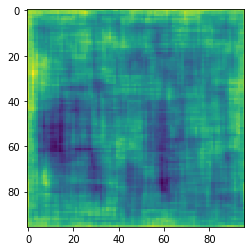

In [14]:
# Test generator
generator = build_generator(SEED_SIZE)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [15]:
generated_image.shape

TensorShape([1, 96, 96, 3])

# Load previous saved discriminator or create a new one

In [15]:
try:
    discriminator = load_model('./Models/discriminator.h5')
except OSError:
    discriminator = build_discriminator(IMAGE_SHAPE)

In [16]:
# Test discriminator
discriminator = build_discriminator(IMAGE_SHAPE)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49941167]], shape=(1, 1), dtype=float32)


# Create loss function for generator and discriminator

In [17]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Deifne optimizers for generator and discriminator

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

# Create function to print and save generated images after particular number of epochs 

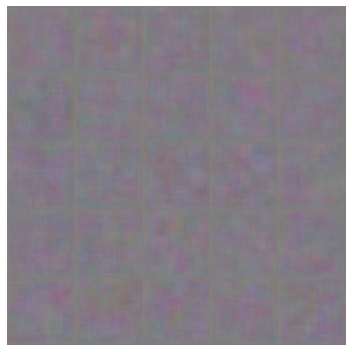

In [19]:
def save_fake_images(noise, rows, cols, epoch, img_dir='Generated_Images', verbose=1):
    
    ''' Generated images'''
    plt.figure(figsize=(rows, cols))
    gs1 = gs.GridSpec(rows, cols)
    gs1.update(wspace=0, hspace=0)
    generated_images = generator.predict(noise)

    for i in range(rows*cols):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = generated_images[i]
        image = denorm(image).astype('int')
        fig = plt.imshow(image)
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
    plt.tight_layout()
    plt.savefig(os.path.join(os.getcwd(), img_dir, str(epoch).zfill(5) + "_fake_images.png"),
                bbox_inches='tight', 
                pad_inches=0)
    
    if verbose:
        plt.show()

# test this function
fixed_seed = np.random.normal(0, 1, (5 * 5, SEED_SIZE))
save_fake_images(fixed_seed, 5, 5, 1)

# Create function to convert to nice printing format

In [20]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Create train step function

In [21]:
# Notice the use of `tf.function` to increase performane
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    return gen_loss,disc_loss

# Create placeholders for generator and discriminator training history

In [22]:
# try to open previously saved generator training history or create new list
try:
    with open('./Training_History/gen_loss_history.pickle', 'rb') as f:
        gen_loss_history = pickle.load(f)
except FileNotFoundError:
    gen_loss_history = []
    # dump empty genetator list 
    with open('./Training_History/gen_loss_history.pickle', 'wb') as f:
        pickle.dump(gen_loss_history, f, pickle.HIGHEST_PROTOCOL)

# try to open previously saved discriminator training history or create new list
try:
    with open('./Training_History/disc_loss_history.pickle', 'rb') as f:
        disc_loss_history = pickle.load(f)
except FileNotFoundError:
    disc_loss_history = []
    # dump empty discriminator list 
    with open('./Training_History/disc_loss_history.pickle', 'wb') as f:
        pickle.dump(disc_loss_history, f, pickle.HIGHEST_PROTOCOL)

# Create train function

In [23]:
def train(dataset, start_epoch, num_epochs):
    
    fixed_seed = np.random.normal(0, 1, (ROWS * COLS, SEED_SIZE))
    start = time.time()
    
    # define final epoch
    end_epoch = start_epoch + num_epochs

    for epoch in range(start_epoch, end_epoch):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []
        
        # shuffle dataset in each epoch
        dataset=dataset.shuffle(BUFFER_SIZE)
        
        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

            g_loss = sum(gen_loss_list) / len(gen_loss_list)
            d_loss = sum(disc_loss_list) / len(disc_loss_list)
        # add losses to training history
        gen_loss_history.append(g_loss)
        disc_loss_history.append(d_loss)
        
        epoch_elapsed = time.time()-epoch_start

        if epoch % 50 == 0:
            # print losses and save images
            print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
            save_fake_images(fixed_seed, ROWS, COLS, epoch+1, img_dir='Generated_Images', verbose=1)
            
            # overwrite models after each 50 epochs
            # generator.save(f'./Models/generator_epoch_{epoch+1}.h5')
            # discriminator.save(f'./Models/discriminator_epoch_{epoch+1}.h5')
            
            # save generator training history
            with open('./Training_History/gen_loss_history.pickle', 'wb') as f:
                pickle.dump(gen_loss_history, f, pickle.HIGHEST_PROTOCOL)
            
            # save discriminator training history
            with open('./Training_History/disc_loss_history.pickle', 'wb') as f:
                pickle.dump(disc_loss_history, f, pickle.HIGHEST_PROTOCOL)
            
    
    # print total training time in session
    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')
    
    # save final models to easy reuse them 
    generator.save('./Models/generator.h5')
    discriminator.save('./Models/discriminator.h5')
    
    # save final generator training history
    with open('./Training_History/gen_loss_history.pickle', 'wb') as f:
        pickle.dump(gen_loss_history, f, pickle.HIGHEST_PROTOCOL)

    # save final discriminator training history
    with open('./Training_History/disc_loss_history.pickle', 'wb') as f:
        pickle.dump(disc_loss_history, f, pickle.HIGHEST_PROTOCOL)

# Train GANS

Epoch 1, gen loss=0.6410093903541565,disc loss=1.1552032232284546, 0:00:12.99


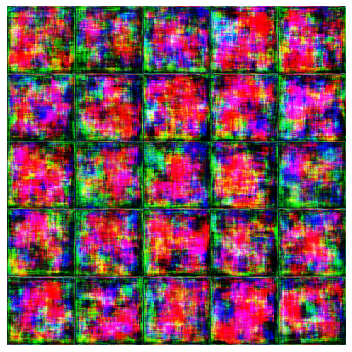

Epoch 51, gen loss=0.6903671622276306,disc loss=1.0314888954162598, 0:00:06.78


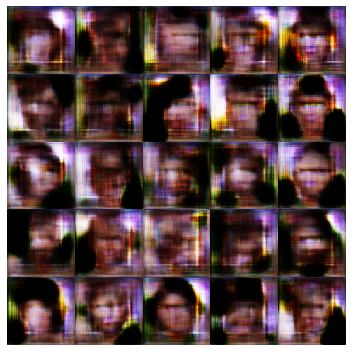

Epoch 101, gen loss=0.6791442036628723,disc loss=1.0537757873535156, 0:00:06.81


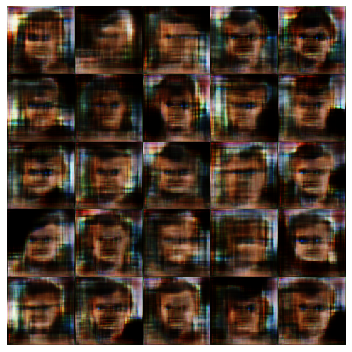

Epoch 151, gen loss=0.6859145760536194,disc loss=1.0387635231018066, 0:00:06.88


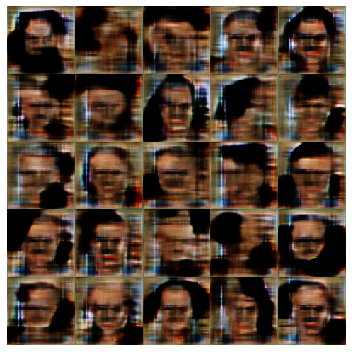

Epoch 201, gen loss=0.6931475400924683,disc loss=1.0064088106155396, 0:00:06.89


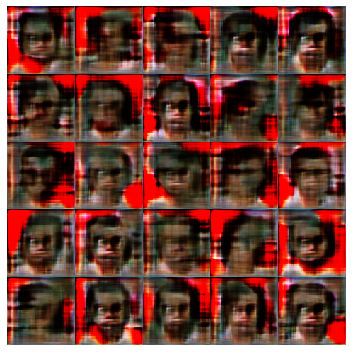

Epoch 251, gen loss=0.6931473612785339,disc loss=1.006408929824829, 0:00:06.92


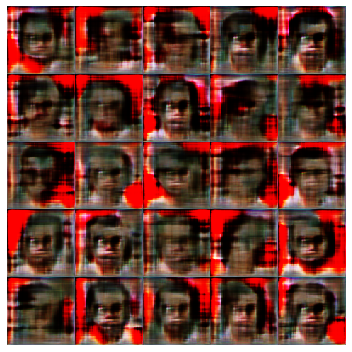

Epoch 301, gen loss=0.6931475400924683,disc loss=1.0064088106155396, 0:00:06.97


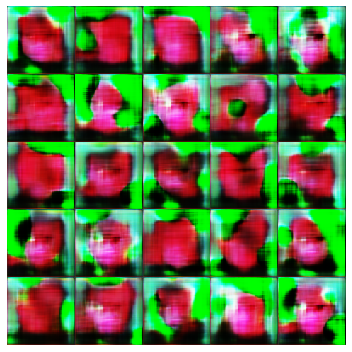

Epoch 351, gen loss=0.6931471228599548,disc loss=1.0064091682434082, 0:00:07.03


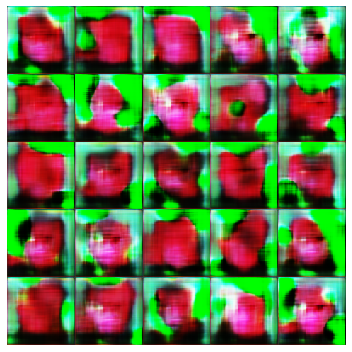

Epoch 401, gen loss=0.6931475400924683,disc loss=1.0064088106155396, 0:00:07.08


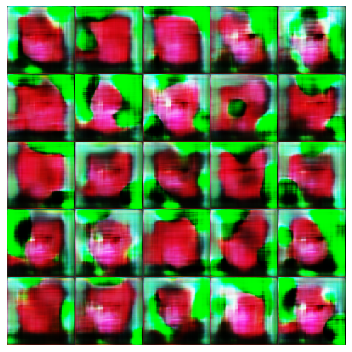

Epoch 451, gen loss=0.6931475400924683,disc loss=1.0064088106155396, 0:00:07.12


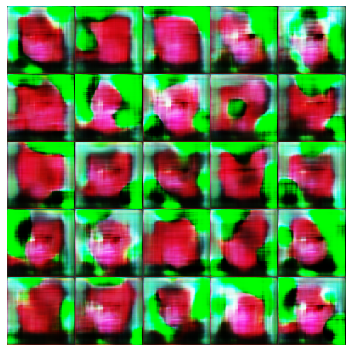

Epoch 501, gen loss=0.6931475400924683,disc loss=1.0064088106155396, 0:00:07.20


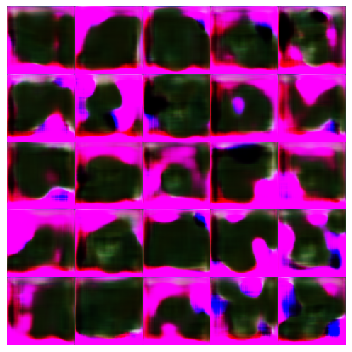

Epoch 551, gen loss=0.6931475400924683,disc loss=1.0064088106155396, 0:00:07.23


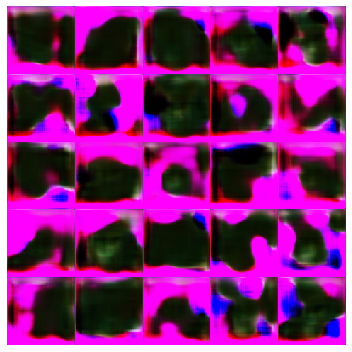

Epoch 601, gen loss=0.6931475400924683,disc loss=1.0064088106155396, 0:00:07.28


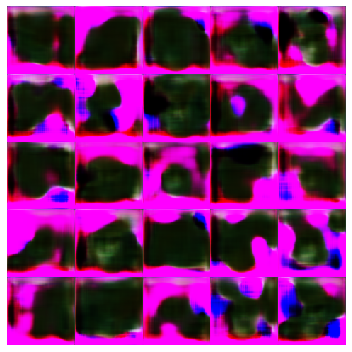

Epoch 651, gen loss=0.6931475400924683,disc loss=1.0064088106155396, 0:00:07.36


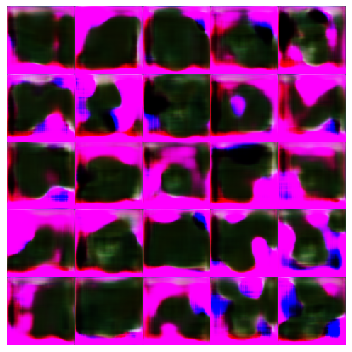

Epoch 701, gen loss=0.6931475400924683,disc loss=1.0064088106155396, 0:00:07.41


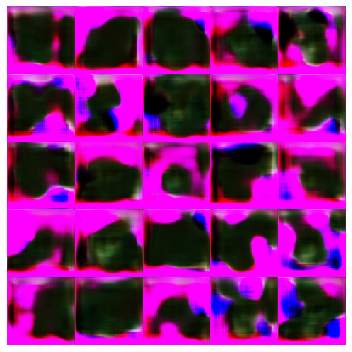

Epoch 751, gen loss=0.6931475400924683,disc loss=1.0064088106155396, 0:00:07.51


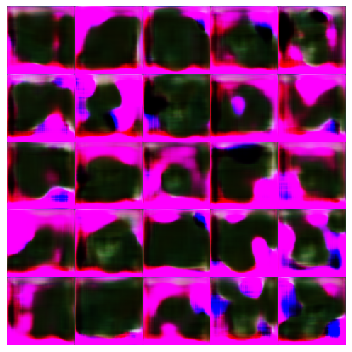

KeyboardInterrupt: 

In [24]:
train(train_images, START_EPOCH, NUM_EPOCHS)